# Problem Statement

Make a model to predict the Customer Churn of a telecom Company.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [86]:
customer_churn = pd.read_csv('telecom_churn.csv')
customer_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [87]:
customer_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Preprocessing

In [88]:
customer_churn.drop(columns=['customerID'],inplace=True)

In [89]:
customer_churn['MonthlyCharges'] = pd.to_numeric(customer_churn['MonthlyCharges'])
customer_churn['TotalCharges'] = pd.to_numeric(customer_churn['TotalCharges'],errors='coerce')

In [90]:
# Creating functions to use in future
def print_cat_unique(df):
    '''Prints unique values of categorical columns.'''
    for col in df:
        if df[col].dtypes == 'object':
            print(f'{col}: {df[col].unique()}')

def auto_or_manual(value):
    '''Create a new column for automatic or manual in dataframe.'''
    val =value.split('(')
    value = val[-1].split(')')
    if value[0] == 'automatic':
        return 1
    else:
        return 0

In [91]:
print_cat_unique(customer_churn)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [92]:
customer_churn.replace('No phone service','No', inplace=True)
customer_churn.replace('No internet service','No',inplace=True)

In [93]:
customer_churn['Automatic'] = customer_churn['PaymentMethod'].apply(auto_or_manual)

In [94]:
# Conveting categorical to numerical values
customer_churn['Churn'] = np.where(customer_churn['Churn'] == 'Yes',1,0)

In [95]:
# Checking for null values.
customer_churn.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
Automatic            0
dtype: int64

I tried filling null values with mean and median but as the null values is very less, filling null values won't make much difference. Therefore we can drop it.

In [96]:
df = customer_churn.copy()
df = df.dropna(how='any',axis=0)

Range of Tenure, Monthly Charges and Total Charges is very large compared to other values, so we scale them for the model.

In [97]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()    # Scale values in the range of 0 to 1
columns_to_scale = ['tenure','MonthlyCharges','TotalCharges']
df[columns_to_scale] = minmax.fit_transform(df[columns_to_scale])

In [98]:
# Functions for modeling
def lr_model(df=pd.DataFrame(),X=None,y=None):
    '''Splits dataframe into train and test then applies logistic regression on it.
    df: pd.DataFrame to use for logistic regression.default value is None.
    X: independent variables. Defualt value is None.
    y: dependent variable. Default value is None.
    Returns:
        y_test: true value of the test dataset.
        y_pred: predicted value of the test dataset.
    '''
    if df.empty:
        X = X
        y = y
    else:
        X = df.drop('Churn',axis=1)
        y = df['Churn']

    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)
    model = LogisticRegression()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return (y_test,y_pred)

def score_check(y_true,y_pred):
    '''Returns Accuracy Score, Precision Score, Recall Score and F1 Score.'''
    print('Accuracy Score:', accuracy_score(y_true,y_pred)) #Correct classification/ total classification
    print('Precision Score:', precision_score(y_true,y_pred)) # proportion of positive prediction was actually correct
    print('Recall Score:', recall_score(y_true,y_pred)) # proportion of positive predicted correct.
    print('F1 Score:', f1_score(y_true,y_pred))

In [100]:
df_dummies = pd.get_dummies(df)
y_true, y_pred = lr_model(df_dummies)

In [101]:
score_check(y_true,y_pred)

Accuracy Score: 0.7874911158493249
Precision Score: 0.6213592233009708
Recall Score: 0.5133689839572193
F1 Score: 0.5622254758418741


## Handling Imbalanced Data

In [102]:
df['Churn'].value_counts(normalize=True)

0    0.734215
1    0.265785
Name: Churn, dtype: float64

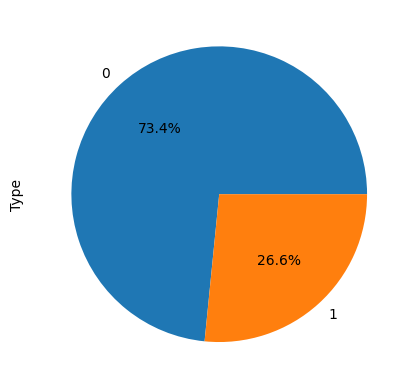

In [103]:
df.groupby('Churn').size().plot(kind='pie',y='Churn',label = "Type",autopct='%1.1f%%')
plt.show()

The data is highly imbalanced. We can handle it using two techniques: Downsampling or Upsampling.

### Downsampling

In [105]:
# Dividing data into Churned and Not Churned
churn = df_dummies[df_dummies['Churn'] == 1]
notchurn = df_dummies[df_dummies['Churn'] == 0]

In [106]:
# Resampling to have same number of observations

from sklearn.utils import resample
notchurned_resample = resample(notchurn,replace=True,n_samples=len(churn),random_state=42)

1    1869
0    1869
Name: Churn, dtype: int64


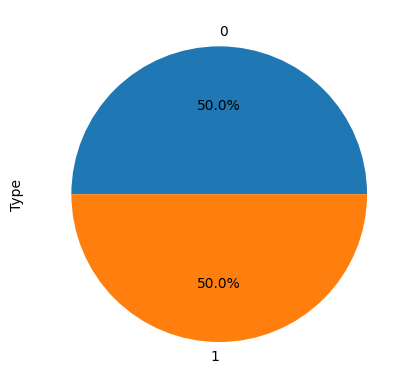

In [107]:
new_df = pd.concat([churn,notchurned_resample])
print(new_df['Churn'].value_counts())
new_df.groupby('Churn').size().plot(kind='pie',y='Churn',label = "Type",autopct='%1.1f%%')
plt.show()

In [108]:
y_true, y_pred = lr_model(new_df)
score_check(y_true,y_pred)

Accuracy Score: 0.7606951871657754
Precision Score: 0.7450980392156863
Recall Score: 0.8021108179419525
F1 Score: 0.7725540025412961


**Con of using downsampling:** Valuable information is lost.

### Up sampling

We will use SMOTE for over sampling. SMOTE stands for Synthetic Minority Oversampling Technique.

In [109]:
from imblearn.over_sampling import SMOTE

In [110]:
smote = SMOTE()
X = df_dummies.drop('Churn',axis=1)
y = df_dummies['Churn']
X, y = smote.fit_resample(X,y)

0    5163
1    5163
Name: Churn, dtype: int64


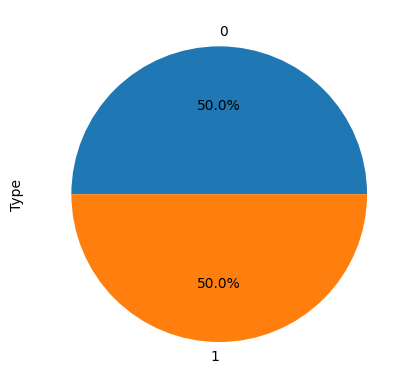

In [111]:
print(y.value_counts())
y.value_counts().plot(kind='pie',y='Churn',label = "Type",autopct='%1.1f%%')
plt.show()

In [112]:
y_true, y_pred = lr_model(X=X,y=y)
score_check(y_true,y_pred)

Accuracy Score: 0.8359148112294289
Precision Score: 0.833011583011583
Recall Score: 0.8386783284742468
F1 Score: 0.8358353510895884


Up sampling gives better results because there is no loss of the information here.

In [113]:
# We will use over sampled data for further analysis
new_df = pd.concat([X,y],axis=1)
new_df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Automatic,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,0.000000,0.115423,0.001275,0,1,0,0,1,1,...,1,0,0,0,1,0,0,1,0,0
1,0,0.464789,0.385075,0.215867,0,0,1,1,0,1,...,0,1,0,1,0,0,0,0,1,0
2,0,0.014085,0.354229,0.010310,0,0,1,1,0,1,...,1,0,0,0,1,0,0,0,1,1
3,0,0.619718,0.239303,0.210241,1,0,1,1,0,1,...,0,1,0,1,0,1,0,0,0,0
4,0,0.014085,0.521891,0.015330,0,1,0,1,0,1,...,1,0,0,0,1,0,0,1,0,1


## Some other models

In [114]:
X_train, X_test, y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)

### Support Vector Classifier

In [115]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
score_check(y_test,y_pred)

Accuracy Score: 0.8402710551790901
Precision Score: 0.8403115871470301
Recall Score: 0.8386783284742468
F1 Score: 0.8394941634241244


### KNeighbors Classifier

In [116]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
score_check(y_test,y_pred)

Accuracy Score: 0.824298160696999
Precision Score: 0.7803030303030303
Recall Score: 0.9008746355685131
F1 Score: 0.8362652232746955


### Decision Tree Classifier

In [117]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train,y_train)
y_pred = decision_tree.predict(X_test)
score_check(y_test,y_pred)

Accuracy Score: 0.7691190706679574
Precision Score: 0.7679611650485437
Recall Score: 0.7687074829931972
F1 Score: 0.7683341427877611


### Random Forest Classifier

In [118]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
random_forest.fit(X_train,y_train)
y_pred = random_forest.predict(X_test)
score_check(y_test,y_pred)

Accuracy Score: 0.8518877057115198
Precision Score: 0.8388003748828491
Recall Score: 0.86977648202138
F1 Score: 0.8540076335877862


### Improving Logistic Regression Model

In [119]:
from sklearn.model_selection import GridSearchCV

In [120]:
tuned_parameters = [{'penalty' : ['l1', 'l2', 'elasticnet'],'tol':[1e4,1e3,1e2,1e1,1e0,1e-1,1e-2,1e-3,1e-4],'C':[10**-4,10**-2,10**0,10**2,10**4]}]
X_train, X_test, y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)

model = GridSearchCV(LogisticRegression(random_state=42),tuned_parameters,scoring='f1')

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(model.best_estimator_)
score_check(y_test,y_pred)

LogisticRegression(C=100, random_state=42, tol=1.0)
Accuracy Score: 0.8354307841239109
Precision Score: 0.8367546432062561
Recall Score: 0.8318756073858115
F1 Score: 0.834307992202729


# Saving the Model

Since Random Forest performs best, we will save it for future use cases.

In [121]:
final_model = RandomForestClassifier()
pickle.dump(final_model, open('RandomForest.pkl','wb'))